In [18]:
import pandas as pd
import seaborn as sns

Распарсим выдачу hmm2search

In [2]:
with open("short_res.txt","r") as fin:
    fin.readline()
    head = ["Sequence","Score","E-value"]
    res = {i: [] for i in head}
    for line in fin:
        res["Sequence"].append(line[0:54].split("|")[1])
        res["Score"].append(float(line[56:62]))
        res["E-value"].append(float(line[64:73]))
res = pd.DataFrame(res)

Загрузим табличку со списком белков, в которых на самом деле есть интересующая нас двухдоменная архитектура.

In [3]:
our = pd.read_csv("domains_prots.csv")

Добавим в выдачу hmm2search колонку True, обозначающую, обладает ли данный белок на самом деле выбранной архитектурой.

In [4]:
real = res.Sequence.isin(our.Entry)
res["True"] = real
res = res.sort_values(by="Score",ascending=False)

Для каждого порогового значения Score посчитаем TPR (=True Positive Rate=чувствительность=мощность), FPR (=False Positive Rate=1-специфичность), PPV (=Positive Predictive Value=точность) и F1-score (=гармоническое среднее точности и чувствительности).

In [24]:
ROC = {"Score":[],"FPR": [], "TPR": [], "PPV": [], "F1": []}
for i in res.Score:
    TP = res["True"].loc[res.Score>=i].sum()
    FP = res["True"].loc[res.Score>=i].size - TP
    FN = res["True"].loc[res.Score<i].sum()
    TN = res["True"].loc[res.Score<i].size - FN
    FPR = FP/(FP+TN)
    TPR = TP/(FN+TP)
    PPV = TP/(TP+FP)
    F1 = 2*TP/(2*TP+FP+FN)
    ROC["FPR"].append(FPR)
    ROC["TPR"].append(TPR)
    ROC["PPV"].append(PPV)
    ROC["F1"].append(F1)
    ROC["Score"].append(i)
ROC = pd.DataFrame(ROC)

Построим для наших данных ROC-кривую.

[Text(0.5, 1.0, 'ROC curve')]

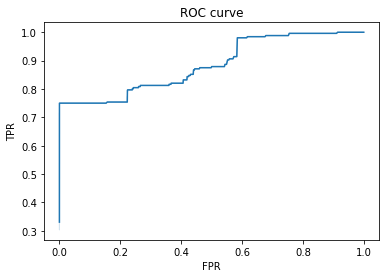

In [31]:
sns.lineplot(x=ROC.FPR,y=ROC.TPR).set(title="ROC curve")

Для нашей цели (предсказание наличия у белка доменной архитектуры) наиболее важна чувствительность: минимизировать долю ложноположительных результатов важнее, чем максимизировать долю верно предсказанных архитектур (в разумных пределах, разумеется).

Поэтому по кривой ROC кажется, что стоит взять порог, соответствующий левому нижнему изгибу кривой - так мы получим достаточно высокий TPR (около 0.75) при низком FPR (<0.05).

Построим график того, как убывает score находок.

[Text(0.5, 0, 'Index')]

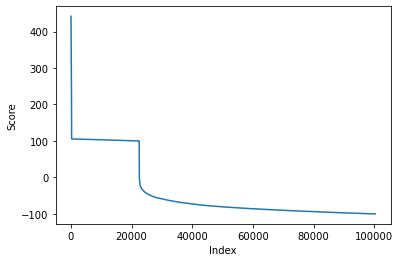

In [20]:
sns.lineplot(x=range(0,ROC.shape[0]),y=ROC.Score).set(xlabel="Index")

Из этого графика кажется, что стоит подобрать порог score немного выше ста.

Однако посмотрим, наконец, на F1-score, который учитывает как точность, так и чувствительность.

In [30]:
ROC.iloc[ROC.F1.idxmax()]

Score    235.100000
FPR        0.000020
TPR        0.746094
PPV        0.989637
F1         0.850780
Name: 192, dtype: float64

[Text(0.5, 0, 'Index')]

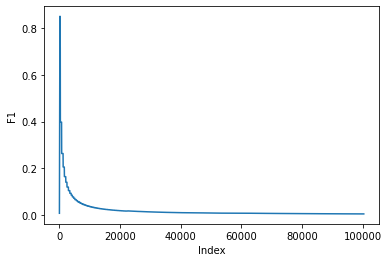

In [29]:
sns.lineplot(x=range(0,ROC.shape[0]),y=ROC.F1).set(xlabel="Index")

Из полученных по F1-score данных совершенно очевидно, что нужно брать порог, соответствующий максимальному F1-score. Тем более, что это как раз совпадает с предложенной по кривой ROC точкой: FRP=0.00002, TRP=0.746, PPV = 0.99.

Таким образом, при пороговом score = 235.1 мы максимизируем чувствительность, при этом сохраняя достаточно неплохую мощность и очень высокую точность.